In [1]:
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import model_from_json
from keras.utils import multi_gpu_model 
from keras.utils import to_categorical


Using TensorFlow backend.


Read the data
===========

In [55]:
x_original=pd.read_csv('../../_xlable4_withNa_AllColumns.txt')
y_original=pd.read_csv('../../_targelable4_withNa_AllColumns.txt')

x_original=x_original[['Unnamed: 0','L101400', 'L500700', 'L103600', 'L190900', 'L191200',
       'L107500', 'L102400', 'L100300', 'L500800', 'AGE', 'L100100','SEX',
                      'FIELD_16','FIELD_23','FIELD_15','FIELD_22','FIELD_17','FIELD_24']]

y_original=y_original[['Unnamed: 0','L101400']]


print(x_original.shape)
print(y_original.shape)


(159381, 19)
(159381, 2)


In [56]:
# for index,col in enumerate(x_original.columns):
#     print(col,x_original[col].dropna().shape[0])

Prepare the data
============

In [57]:
data= pd.merge(x_original,y_original, how='inner',left_on='Unnamed: 0', right_on='Unnamed: 0')
data=data.dropna(). reset_index()

print(data.shape)

(26593, 21)


In [58]:
# filter the data set
data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

data = data[
    data.FIELD_15 != 1
]  # exclude people who are diagnosed for (high blood pressure)
data = data[
    data.FIELD_22 != 1
]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24 != 1
]  # exclude people who are on medication for hyperlipidemia
print(data.shape)

(26593, 21)


In [59]:
print(data.shape)
print(data.columns)
data.head()

(26593, 21)
Index(['index', 'Unnamed: 0', 'L101400_x', 'L500700', 'L103600', 'L190900',
       'L191200', 'L107500', 'L102400', 'L100300', 'L500800', 'AGE', 'L100100',
       'SEX', 'FIELD_16', 'FIELD_23', 'FIELD_15', 'FIELD_22', 'FIELD_17',
       'FIELD_24', 'L101400_y'],
      dtype='object')


,index,Unnamed: 0,L101400_x,L500700,L103600,L190900,L191200,L107500,L102400,L100300,...,AGE,L100100,SEX,FIELD_16,FIELD_23,FIELD_15,FIELD_22,FIELD_17,FIELD_24,L101400_y
0,0,0,228.0,0.87,104.0,13.2,9.8,1.8,45.0,2.5,...,44.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,279.0
1,1,1,279.0,1.13,106.0,13.7,10.0,1.6,42.0,3.1,...,45.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,314.0
2,3,3,273.0,1.08,105.0,13.3,8.2,1.5,54.0,2.7,...,51.0,6.8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,271.0
3,5,5,352.0,1.10,104.0,13.6,8.1,1.5,29.0,2.7,...,63.0,6.7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,362.0
4,6,6,270.0,1.21,106.0,12.8,9.9,1.7,68.0,2.5,...,36.0,6.8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,288.0


In [60]:

x=data[['L101400_x', 'L500700', 'L103600', 'L190900', 'L191200',
       'L107500', 'L102400', 'L100300', 'L500800', 'AGE', 'L100100','SEX']]

y=data[['L101400_y' ]]

Check the correlation of the selected feature with the independent variables
=====

In [61]:
temppd=pd.DataFrame(x.copy())
temppd['y']=y.L101400_y
temppd.head()
corval=abs(temppd.corr()).sort_values(by='y', ascending=False)

In [62]:
corval.y

y            1.000000
L101400_x    0.311220
L103600      0.194318
L100300      0.185627
L500700      0.183523
L107500      0.177060
L191200      0.172512
L190900      0.151035
L100100      0.134689
L102400      0.124952
L500800      0.123934
SEX          0.094683
AGE          0.054705
Name: y, dtype: float64

In [63]:
#histogram plot of the features
# import matplotlib.pyplot as plt
# x[x.dtypes[(x.dtypes=="float64")|(x.dtypes=="int64")]
#                         .index.values].hist(figsize=[11,11])

Apply PCA
===========

In [64]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=8)
# pca.fit(x)

# print(pca.explained_variance_ratio_)   
# print(np.sum(pca.explained_variance_ratio_))

# x=pca.fit_transform(x) 
# print(x.shape)


feature scaling
=======

In [65]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()  #StandardScaler()
# x = min_max_scaler.fit_transform(x)

clustring test
==========

In [66]:
# from sklearn.cluster import KMeans
# from scipy.spatial.distance import cdist

# K = range(1,10)
# distortions = []

# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(x)
#     kmeanModel.fit(x)
#     distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()


In [67]:
# kmeanModel = KMeans(n_clusters=k).fit(x)
# x['lbl']=kmeanModel.labels_ 

In [68]:
# x.columns

Random Forest Regressor
=============

In [69]:
ylable=y[['L101400_y']]  
xtrain,xtest,ytrain,ytest=train_test_split(x, ylable, random_state=42, test_size=0.2)

In [70]:
regr = RandomForestRegressor(max_depth=7, random_state=0,verbose =0,n_estimators=500)
regr.fit(xtrain, ytrain) 
print(regr.feature_importances_)
ypred=regr.predict(xtest)


[0.40176524 0.15989837 0.09293647 0.19036    0.02996984 0.02748195
 0.04249145 0.02097967 0.01476838 0.01143878 0.00612183 0.00178801]


mean_squared_error 4437.814480984593
root mean_squared_error 66.61692338276058
mean_absolute_error 46.59638286409775
r2_score 0.27748741583318526


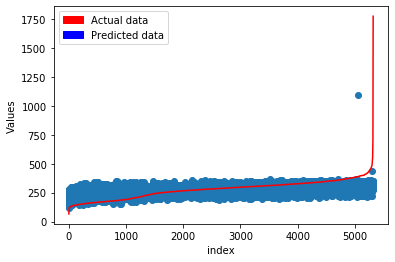

,t + 1,pred (t +1)
430,557.0,352.413682
2557,596.0,352.522663
4963,626.0,354.061015
1525,668.0,339.524062
3372,676.0,331.999941
3555,709.0,271.334722
5035,897.0,301.849698
2974,907.0,281.831547
3868,929.0,287.383807
889,1777.0,319.142689


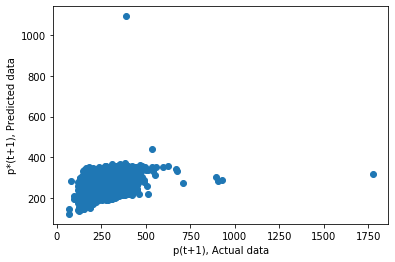

In [71]:

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.tail(10)

In [72]:
# tempdata=pd.DataFrame(xtest.copy())
# tempdata['ytest']=ytest
# # temp=temp.dropna()
# # tempdata.head()
# # tempdata[tempdata.ytest.isna()].index

# tempdata=tempdata.drop(tempdata[tempdata.ytest.isna()].index)


xg boost
==========

In [73]:
import xgboost as xgb
# from sklearn.metrics import mean_squared_error
# import pandas as pd
# import numpy as np

In [74]:
xg_reg = xgb.XGBRegressor()
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, 
#                           learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(xtrain, ytrain) 

[20:27:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [75]:

ypred = xg_reg.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

# ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
# ypredPD['t + 1']=ytest.values
# ypredPD['pred (t +1)']=ypred
# ypredPD.head(10)

mean_squared_error 4190.798543856356
root mean_squared_error 64.73637728399973
mean_absolute_error 45.718162431912354
r2_score 0.31770363573819416


In [24]:
# ytest[ytest.isna()].shape
# tempdata.iloc[:,-1]

ANN
==========

In [40]:
model= Sequential()
model.add(Dense(input_dim=34,units=128,activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=128, activation='relu', kernel_initializer='uniform')) 
# model.add(BatchNormalization())
# model.add(Dropout(0.25))  
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=32, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=16, activation='relu', kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=8, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=1, kernel_initializer='uniform'))
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mean_squared_error' ])

W1004 00:26:52.982615 10444 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1004 00:26:52.995581 10444 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1004 00:26:52.997575 10444 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1004 00:26:53.093015 10444 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1004 00:26:53.117435 10444 deprecation.py:506

In [41]:
h=model.fit(xtrain, ytrain, validation_split=.2,epochs=100, batch_size=50)

W1004 00:26:53.623558 10444 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 32352 samples, validate on 8089 samples
Epoch 1/100
32352/32352 [==============================] - 1s 41us/step - loss: 4.6046 - mean_squared_error: 4.6046 - val_loss: 1.6467 - val_mean_squared_error: 1.6467
Epoch 2/100
32352/32352 [==============================] - 1s 24us/step - loss: 1.1394 - mean_squared_error: 1.1394 - val_loss: 2.4030 - val_mean_squared_error: 2.4030
Epoch 3/100
32352/32352 [==============================] - 1s 24us/step - loss: 0.7273 - mean_squared_error: 0.7273 - val_loss: 1.8084 - val_mean_squared_error: 1.8084
Epoch 4/100
32352/32352 [==============================] - 1s 24us/step - loss: 0.6440 - mean_squared_error: 0.6440 - val_loss: 0.9060 - val_mean_squared_error: 0.9060
Epoch 5/100
32352/32352 [==============================] - 1s 23us/step - loss: 0.6222 - mean_squared_error: 0.6222 - val_loss: 1.2086 - val_mean_squared_error: 1.2086
Epoch 6/100
32352/32352 [==============================] - 1s 24us/step - loss: 0.6125 - mean_squared_error: 0.

32352/32352 [==============================] - 1s 27us/step - loss: 0.5566 - mean_squared_error: 0.5566 - val_loss: 0.7155 - val_mean_squared_error: 0.7155
Epoch 98/100
32352/32352 [==============================] - 1s 27us/step - loss: 0.5533 - mean_squared_error: 0.5533 - val_loss: 0.5762 - val_mean_squared_error: 0.5762
Epoch 99/100
32352/32352 [==============================] - 1s 27us/step - loss: 0.5548 - mean_squared_error: 0.5548 - val_loss: 0.6480 - val_mean_squared_error: 0.6480
Epoch 100/100
32352/32352 [==============================] - 1s 25us/step - loss: 0.5599 - mean_squared_error: 0.5599 - val_loss: 0.7154 - val_mean_squared_error: 0.7154


In [42]:
ypred=model.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)

mean_squared_error 0.7174055272813694
root mean_squared_error 0.8469979499865211
mean_absolute_error 0.6392646479377901
r2_score 0.636315591648466


,t + 1,pred (t +1)
0,5.3,4.723892
1,4.3,5.306175
2,4.2,4.000012
3,6.1,5.396946
4,4.4,5.289919
5,7.1,6.372007
6,5.5,5.720734
7,7.3,5.965288
8,4.2,4.421140
9,6.3,5.605452


dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


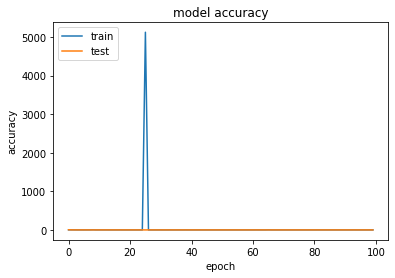

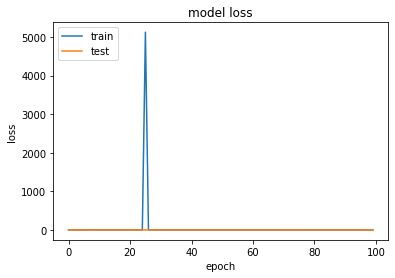

In [43]:
history=h
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
ypredPD['diff']=abs(ypredPD['t + 1']- ypredPD['pred (t +1)'])
print(np.mean(ypredPD['diff']))
print(np.std(ypredPD['diff']))
print(100*ypredPD[ypredPD['diff']<=5].shape[0]/ypredPD.shape[0])

0.6392646479377897
0.555649383315002
99.99010978142617


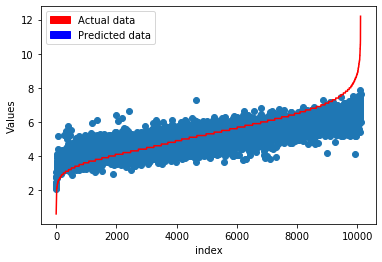

,t + 1,pred (t +1),diff
9432,0.6,2.046516,1.446516
4784,0.7,2.396551,1.696551
91,0.7,2.124404,1.424404
8845,0.8,2.218421,1.418421
2100,0.9,2.339827,1.439827
2068,1.0,2.470100,1.470100
7307,1.3,2.347502,1.047502
4109,1.4,2.792722,1.392722
3492,1.5,2.782716,1.282716
2684,1.5,2.363954,0.863954


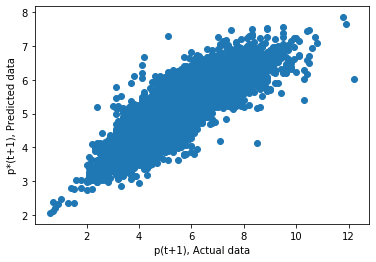

In [45]:

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.head(10)

SVR
======

In [ ]:
from sklearn.svm import SVR
# svr_rbf = SVR(kernel='rbf', C=10, gamma=0.02, epsilon=.001)
svr_rbf = SVR(kernel='rbf')

In [ ]:
svr_rbf.fit(xtrain, ytrain) 

In [ ]:
ypred=svr_rbf.predict(xtest)

In [ ]:
import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)